In [1]:
import torch
import random
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm

In [2]:
def get_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

device = get_device()
print(f"Using {device} device")

Using mps device


In [3]:
IMPORTANCE = (0.7 ** torch.arange(0, 20)).to(device)

In [4]:
class ToyModel(nn.Module):
    def __init__(self, m, n, include_ReLU):
        '''Create a toy model

        Args:
            m (int): the number of neurons (as described in original paper)
            n (int): the number of features the Toy model can map.
            (The weight matrix is delcared to be m * n)

            include_ReLU (bool): if True, a nonlinearity is added to the network
        '''
        super().__init__()
        self.weights = nn.Parameter(torch.randn(m, n), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(n, 1), requires_grad=True)
        self.ReLU = nn.ReLU(inplace=True)
        self.inclue_ReLU = include_ReLU
        
    def forward(self, x): # x is 5 * 1
        # print("w", self.weights)
        # print("x", x)
        hidden = self.weights @ x
        # print("hidden", hidden)
        final = self.weights.T @ hidden
        final += self.bias
        if self.inclue_ReLU:
            return self.ReLU(final)
        else:
            return final

class ImporanceWeightedMSE(nn.Module):
    def __init__(self):
        super(ImporanceWeightedMSE, self).__init__()

    def forward(self, predictions, targets, importance):
        sub_total = ((predictions - targets)**2).sum(0).flatten()
        return sum(sub_total * importance)

In [5]:
def train(model, epochs, total_batchs, batch_size, loss_fn, optimizer, importance, sparsity):
    probability = 1 - sparsity
    model.train()
    loss_total = 0
    for epoch in range(epochs):
        for i in range(total_batchs):
            sparsity_tensor = torch.bernoulli(torch.full((20,1), probability))
            x = torch.rand(batch_size, 20, 1)
            x = (x*sparsity_tensor).to(device)
            pred = model(x)
            loss = loss_fn(pred, x, importance)
            loss_total += loss.item()
    
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print("(EPOCH:", str(epoch + 1) + ")", "--> loss:", loss_total / (total_batchs * batch_size))
        loss_total = 0

### Graph weights as heatmap

In [6]:
def graph_weights(weights, bias):
    fig, axs = plt.subplots(1, 2, figsize=(7, 3.5)) # 1 row, 2 columns
    
    w = weights.clone().cpu().detach()
    to_graph = w.T @ w
    colors = [(.4, 0, 1), (1, 1, 1), (1, .4, 0)]  # Purple -> White -> Orange
    n_bins = 100 
    cm = LinearSegmentedColormap.from_list("", colors, N=n_bins)
    
    norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
    
    axs[0].imshow(to_graph, cmap=cm, norm=norm)
    # ax = plt.gca()
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    graph_biases(bias, axs[1])
    plt.subplots_adjust(left=0.0, right=1.4)
    plt.tight_layout()
    plt.show()

def graph_biases(bias, ax_obj):
  b = bias.clone().detach().cpu()
  colors = [(.4, 0, 1), (1, 1, 1), (1, .4, 0)]  # Purple -> White -> Orange
  n_bins = 100 
  cm = LinearSegmentedColormap.from_list("", colors, N=n_bins)
  
  norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
  
  ax_obj.imshow(b, cmap=cm, norm=norm)

  ax_obj.set_xticks([])
  ax_obj.set_yticks([])


### Graph superposition

In [7]:
def get_superposition_scores(w):
  rv = torch.zeros(20,)
  for i in range(20):
    current_vector = w[i] / torch.norm(w[i])
    the_sum = sum((w @ current_vector.reshape(5, 1)) ** 2)
    the_sum -= (current_vector.reshape(1, 5) @ w[i]) ** 2
    rv[i] = the_sum
  return torch.clamp(rv, max=1)

def graph_superposition(weights):
  w = weights.T.clone().detach().to('cpu')
  categories = [str(i) for i in range(20)]
  super_scores = get_superposition_scores(w).numpy()
  colors = [(0, (i)*(136 /255), (i) * (255/255)) for i in super_scores]
  normed_weights = torch.norm(w, dim=1).numpy()

  plt.barh(categories, normed_weights[::-1], color=colors[::-1], height=1.0)
  plt.axis('off')

  plt.show()


## Training linear model

In [47]:
NUM_EPOCHS = 10
BATCHS_PER_EPOCH = 2000
BATCH_SIZE = 256
LEARNING_RATE = 1e-3

In [48]:
model_0_sparsity = ToyModel(5, 20, False).to(device)

In [49]:
SPARSITY = 0.0
optimizer = torch.optim.Adam(model_0_sparsity.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_0_sparsity, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

(EPOCH: 1) --> loss: 13.842857469916344
(EPOCH: 2) --> loss: 1.0533535557687284
(EPOCH: 3) --> loss: 0.35140590929985044
(EPOCH: 4) --> loss: 0.18546878892928362
(EPOCH: 5) --> loss: 0.11876310168579221
(EPOCH: 6) --> loss: 0.08521280893869698
(EPOCH: 7) --> loss: 0.06186920288950205
(EPOCH: 8) --> loss: 0.04773891006596386
(EPOCH: 9) --> loss: 0.04649249793216586
(EPOCH: 10) --> loss: 0.046475054724141956


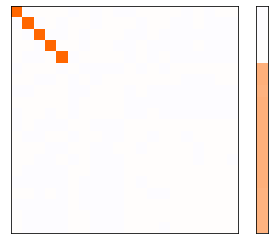

In [381]:
graph_weights(model_0_sparsity.weights, model_0_sparsity.bias)

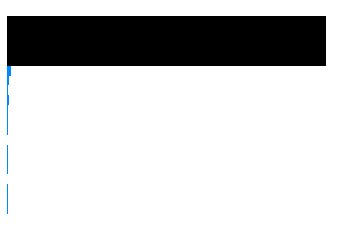

In [382]:
graph_superposition(model_0_sparsity.weights)

## Training ReLU Model (0 sparsity)

In [54]:
NUM_EPOCHS = 10
BATCHS_PER_EPOCH = 2000
BATCH_SIZE = 256
LEARNING_RATE = 1e-3

In [55]:
model_0_sparsity_relu = ToyModel(5, 20, True).to(device)

In [56]:
SPARSITY = 0.0
optimizer = torch.optim.Adam(model_0_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_0_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

(EPOCH: 1) --> loss: 10.766251503407956
(EPOCH: 2) --> loss: 1.5236820839047431
(EPOCH: 3) --> loss: 0.9780914185345173
(EPOCH: 4) --> loss: 0.8278457116782665
(EPOCH: 5) --> loss: 0.6160252014994622
(EPOCH: 6) --> loss: 0.4967609033957124
(EPOCH: 7) --> loss: 0.14626913760602475
(EPOCH: 8) --> loss: 0.08215297842212022
(EPOCH: 9) --> loss: 0.05461258794367314
(EPOCH: 10) --> loss: 0.049700586959719656


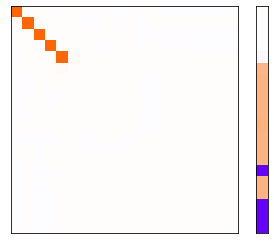

In [379]:
graph_weights(model_0_sparsity_relu.weights, model_0_sparsity_relu.bias)

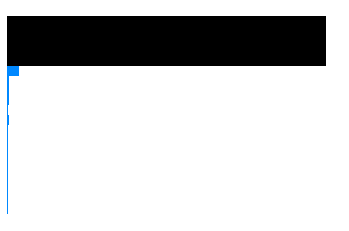

In [380]:
graph_superposition(model_0_sparsity_relu.weights)

## Training ReLU Model (70% sparsity)

In [11]:
NUM_EPOCHS = 10
BATCHS_PER_EPOCH = 5000
BATCH_SIZE = 256 # 128 gets to 0.04 loss
LEARNING_RATE = 1e-2 # 1e-3

In [363]:
model_70_sparsity_relu = ToyModel(5, 20, True).to(device)

In [364]:
SPARSITY = 0.70
optimizer = torch.optim.RMSprop(model_70_sparsity_relu.parameters(), lr=LEARNING_RATE) # 0.038
# optimizer = torch.optim.Adagrad(model_70_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_70_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

(EPOCH: 1) --> loss: 0.18791197230252438
(EPOCH: 2) --> loss: 0.053323060688655825
(EPOCH: 3) --> loss: 0.052623294350178915
(EPOCH: 4) --> loss: 0.05242439394602552
(EPOCH: 5) --> loss: 0.053103617068659514
(EPOCH: 6) --> loss: 0.05308440730543807
(EPOCH: 7) --> loss: 0.05228355869646184
(EPOCH: 8) --> loss: 0.05246755323163234
(EPOCH: 9) --> loss: 0.05269760336992331
(EPOCH: 10) --> loss: 0.052866906332410875


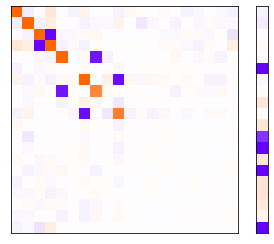

In [365]:
graph_weights(model_70_sparsity_relu.weights, model_70_sparsity_relu.bias.clone().detach().to('cpu'))

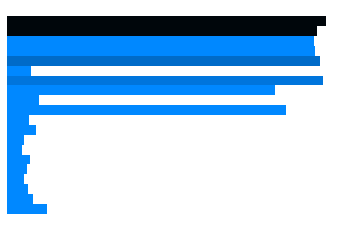

In [366]:
graph_superposition(model_70_sparsity_relu.weights)

## Training ReLU Model (90% sparsity)

In [368]:
model_90_sparsity_relu = ToyModel(5, 20, True).to(device)

In [369]:
SPARSITY = 0.90
optimizer = torch.optim.RMSprop(model_90_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_90_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

(EPOCH: 1) --> loss: 0.1637521715469478
(EPOCH: 2) --> loss: 0.032171906085189904
(EPOCH: 3) --> loss: 0.03293396102156889
(EPOCH: 4) --> loss: 0.03344958453163456
(EPOCH: 5) --> loss: 0.03397247432295621
(EPOCH: 6) --> loss: 0.03199498865787832
(EPOCH: 7) --> loss: 0.03095864474018954
(EPOCH: 8) --> loss: 0.031428360554655164
(EPOCH: 9) --> loss: 0.03266427356092802
(EPOCH: 10) --> loss: 0.03125137894442511


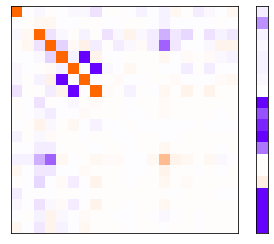

In [370]:
graph_weights(model_90_sparsity_relu.weights, model_90_sparsity_relu.bias)

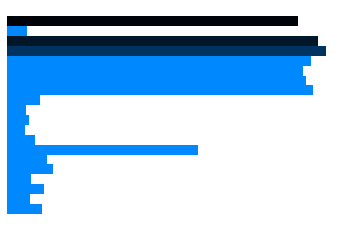

In [371]:
graph_superposition(model_90_sparsity_relu.weights)

# Training ReLU Model (97% sparsity)

In [404]:
NUM_EPOCHS = 20

In [405]:
model_97_sparsity_relu = ToyModel(5, 20, True).to(device)

In [406]:
SPARSITY = 0.97
optimizer = torch.optim.Adam(model_97_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_97_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

(EPOCH: 1) --> loss: 0.18276074473055096
(EPOCH: 2) --> loss: 0.006851968074352433
(EPOCH: 3) --> loss: 0.006084421046498096
(EPOCH: 4) --> loss: 0.006229419469541005
(EPOCH: 5) --> loss: 0.005610235935434403
(EPOCH: 6) --> loss: 0.005727926660485687
(EPOCH: 7) --> loss: 0.005783828550114192
(EPOCH: 8) --> loss: 0.0057636084664351795
(EPOCH: 9) --> loss: 0.006129722006329713
(EPOCH: 10) --> loss: 0.005771389922062923
(EPOCH: 11) --> loss: 0.006045597088224364
(EPOCH: 12) --> loss: 0.006330292554872781
(EPOCH: 13) --> loss: 0.005826227479573489
(EPOCH: 14) --> loss: 0.005316366986804621
(EPOCH: 15) --> loss: 0.005883064103928893
(EPOCH: 16) --> loss: 0.006242403885943514
(EPOCH: 17) --> loss: 0.0056645960537821775
(EPOCH: 18) --> loss: 0.00560996518231029
(EPOCH: 19) --> loss: 0.00550440342519432
(EPOCH: 20) --> loss: 0.005605766112171835


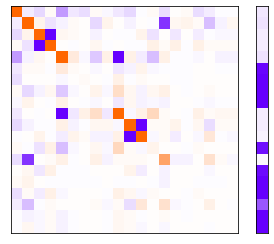

In [407]:
graph_weights(model_97_sparsity_relu.weights, model_97_sparsity_relu.bias )

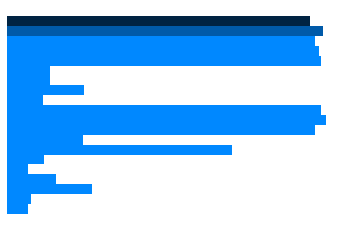

In [408]:
graph_superposition(model_97_sparsity_relu.weights)

# Training ReLU Model (99% sparsity)

In [12]:
NUM_EPOCHS = 20

In [13]:
model_99_sparsity_relu = ToyModel(5, 20, True).to(device)

In [14]:
SPARSITY = 0.99
optimizer = torch.optim.Adam(model_99_sparsity_relu.parameters(), lr=LEARNING_RATE) # originally Adam
loss_func = ImporanceWeightedMSE()

train(model_99_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

(EPOCH: 1) --> loss: 0.022704872801743863
(EPOCH: 2) --> loss: 0.0015297479240311076
(EPOCH: 3) --> loss: 0.0013360056174715035
(EPOCH: 4) --> loss: 0.0011009516383077198
(EPOCH: 5) --> loss: 0.0009906485143259206
(EPOCH: 6) --> loss: 0.0011670010887066384
(EPOCH: 7) --> loss: 0.0010132941153863683
(EPOCH: 8) --> loss: 0.0009475275541525464
(EPOCH: 9) --> loss: 0.0009145875611005656
(EPOCH: 10) --> loss: 0.0010312688053875031
(EPOCH: 11) --> loss: 0.0009375832313053003
(EPOCH: 12) --> loss: 0.001104420249577262
(EPOCH: 13) --> loss: 0.0008740211467766873
(EPOCH: 14) --> loss: 0.0009262653860985284
(EPOCH: 15) --> loss: 0.0010386281389786753
(EPOCH: 16) --> loss: 0.0008590078360388105
(EPOCH: 17) --> loss: 0.0009824767901865832
(EPOCH: 18) --> loss: 0.000852970735424612
(EPOCH: 19) --> loss: 0.0008359489011704149
(EPOCH: 20) --> loss: 0.001020050205245973


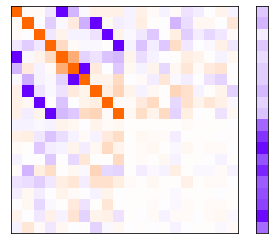

In [15]:
graph_weights(model_99_sparsity_relu.weights,  model_99_sparsity_relu.bias)

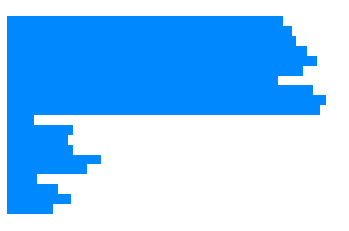

In [16]:
graph_superposition(model_99_sparsity_relu.weights)

## Training ReLU Model (99.7 % sparsity)

In [392]:
model_997_sparsity_relu = ToyModel(5, 20, True).to(device)

In [393]:
SPARSITY = 0.997
optimizer = torch.optim.Adam(model_997_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_997_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

(EPOCH: 1) --> loss: 0.03439775145726656
(EPOCH: 2) --> loss: 0.0012446922538336366
(EPOCH: 3) --> loss: 0.00133725419882976
(EPOCH: 4) --> loss: 0.0011953396836353932
(EPOCH: 5) --> loss: 0.0009007282206886884
(EPOCH: 6) --> loss: 0.0008700919414288364
(EPOCH: 7) --> loss: 0.0007131423181657737
(EPOCH: 8) --> loss: 0.0006728905780010301
(EPOCH: 9) --> loss: 0.0006089376025492863
(EPOCH: 10) --> loss: 0.0005694555321183764
(EPOCH: 11) --> loss: 0.0006295186660008535
(EPOCH: 12) --> loss: 0.0007226209209503409
(EPOCH: 13) --> loss: 0.0006193184768198989
(EPOCH: 14) --> loss: 0.0006328615101217536
(EPOCH: 15) --> loss: 0.0005347739274872094
(EPOCH: 16) --> loss: 0.0005716269653423204
(EPOCH: 17) --> loss: 0.0006109346658496308
(EPOCH: 18) --> loss: 0.0005725993577430927
(EPOCH: 19) --> loss: 0.0005995422743445738
(EPOCH: 20) --> loss: 0.0006485396355488941


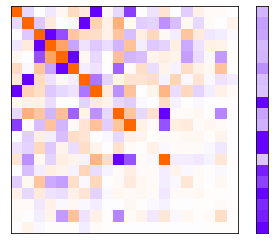

In [394]:
graph_weights(model_997_sparsity_relu.weights,  model_997_sparsity_relu.bias)

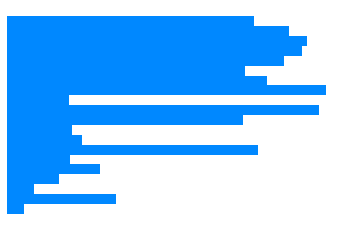

In [395]:
graph_superposition(model_997_sparsity_relu.weights)

## Training ReLU Model (99.9 % sparsity)

In [400]:
model_999_sparsity_relu = ToyModel(5, 20, True).to(device)

In [401]:
SPARSITY = 0.999
optimizer = torch.optim.Adam(model_999_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_999_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

(EPOCH: 1) --> loss: 0.014385373158267717
(EPOCH: 2) --> loss: 0.0005113569987137453
(EPOCH: 3) --> loss: 0.0008675340312402114
(EPOCH: 4) --> loss: 0.0005437255898257718
(EPOCH: 5) --> loss: 0.0007972438831209729
(EPOCH: 6) --> loss: 0.0008201525660435436
(EPOCH: 7) --> loss: 0.001069533774291267
(EPOCH: 8) --> loss: 0.0005667622132339602
(EPOCH: 9) --> loss: 0.0007576098826248199
(EPOCH: 10) --> loss: 0.000785851544513207
(EPOCH: 11) --> loss: 0.0008180537279265991
(EPOCH: 12) --> loss: 0.0008766345118943718
(EPOCH: 13) --> loss: 0.0007270998613177653
(EPOCH: 14) --> loss: 0.0007524248190523394
(EPOCH: 15) --> loss: 0.000600480829924345
(EPOCH: 16) --> loss: 0.0005647836769901915
(EPOCH: 17) --> loss: 0.0005041121495480183
(EPOCH: 18) --> loss: 0.0006600238643178435
(EPOCH: 19) --> loss: 0.0007511271683466888
(EPOCH: 20) --> loss: 0.0005296885104151442


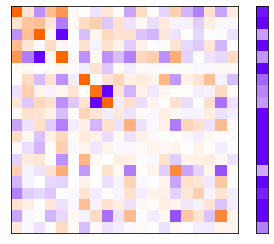

In [402]:
graph_weights(model_999_sparsity_relu.weights, model_999_sparsity_relu.bias)

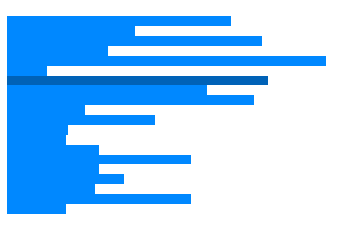

In [403]:
graph_superposition(model_999_sparsity_relu.weights)